<a href="https://colab.research.google.com/github/23520052/DoAnDuLieuLon/blob/main/3_Final_Model_with_BackTranslation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HUẤN LUYỆN TRÊN DỮ LIỆU ĐÃ CÂN BẰNG**

In [ ]:
# --- BƯỚC 1: CÀI ĐẶT & KẾT NỐI ---
!pip install -q transformers torch scikit-learn

import torch
import pandas as pd
import re
import os
import time
import numpy as np
from torch.utils.data import Dataset, DataLoader
# SỬA LỖI: Bỏ AdamW ở dòng này
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
# SỬA LỖI: Import AdamW từ torch.optim
from torch.optim import AdamW
from sklearn.metrics import classification_report
from google.colab import drive

# Kết nối Drive
drive.mount('/content/drive')

# Sửa đường dẫn folder_path nếu cần
folder_path = '/content/drive/My Drive/ABSA_Project'
try:
    os.chdir(folder_path)
    print(f"✅ Đang làm việc tại: {os.getcwd()}")
except:
    print("⚠️ Kiểm tra lại đường dẫn folder_path!")

# Kiểm tra GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Thiết bị: {device}")

# --- BƯỚC 2: HÀM ĐỌC DỮ LIỆU ---
def parse_vlsp_data(file_name):
    lines = []
    try:
        with open(file_name, 'r', encoding='utf-16') as f:
            lines = f.readlines()
    except:
        try:
            with open(file_name, 'r', encoding='utf-8') as f:
                lines = f.readlines()
        except:
            return pd.DataFrame()

    dataset = []
    review_buffer = []
    label_pattern = re.compile(r"\{(.*?),\s*(.*?)\}")

    for line in lines:
        line = line.strip()
        if not line: continue
        if "{" in line and "}" in line and "#" in line:
            current_review = " ".join(review_buffer).strip()
            matches = label_pattern.findall(line)
            for aspect, sentiment in matches:
                if sentiment.lower() != 'none':
                    dataset.append({'text': current_review, 'aspect': aspect.strip(), 'label': sentiment.strip().lower()})
            review_buffer = []
        else:
            review_buffer.append(re.sub(r"^[\_\-]\s*", "", line))
    return pd.DataFrame(dataset)

# --- BƯỚC 3: LOAD DỮ LIỆU ---
print("\n⏳ Đang tải dữ liệu...")

# 1. Load tập Train đã Cân bằng (CSV)
try:
    df_train_balanced = pd.read_csv('1-VLSP2018-Restaurant-Train-BALANCED.csv')
    print(f"✅ Đã tải tập TRAIN (Balanced): {len(df_train_balanced)} dòng")
    # Kiểm tra phân bố
    print("   Phân bố:", df_train_balanced['label'].value_counts().to_dict())
except FileNotFoundError:
    print("❌ LỖI: Không tìm thấy file 'BALANCED.csv'. Bạn kiểm tra lại tên file trong Drive nhé!")

# 2. Load tập Test gốc (TXT)
df_test = parse_vlsp_data('3-VLSP2018-SA-Restaurant-test.txt')
print(f"✅ Đã tải tập TEST (Gốc): {len(df_test)} dòng")

# --- BƯỚC 4: TOKENIZER & DATALOADER ---
print("\n⏳ Đang thiết lập PhoBERT Tokenizer...")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
    def __len__(self): return len(self.df)
    def __getitem__(self, index):
        row = self.df.iloc[index]
        input_text = f"{str(row['aspect'])} {self.tokenizer.sep_token} {str(row['text'])}"
        encoding = self.tokenizer.encode_plus(
            input_text, add_special_tokens=True, max_length=self.max_len,
            padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.label_map[row['label']], dtype=torch.long)
        }

# Tạo DataLoader
BATCH_SIZE = 32
train_loader_balanced = DataLoader(SentimentDataset(df_train_balanced, tokenizer), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(SentimentDataset(df_test, tokenizer), batch_size=BATCH_SIZE)

print("\n🎉 SETUP XONG! Sẵn sàng huấn luyện.")

Mounted at /content/drive
✅ Đang làm việc tại: /content/drive/My Drive/ABSA_Project
🚀 Thiết bị: cuda

⏳ Đang tải dữ liệu...
✅ Đã tải tập TRAIN (Balanced): 21213 dòng
   Phân bố: {'negative': 7071, 'neutral': 7071, 'positive': 7071}
✅ Đã tải tập TEST (Gốc): 2419 dòng

⏳ Đang thiết lập PhoBERT Tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]


🎉 SETUP XONG! Sẵn sàng huấn luyện.


In [ ]:
# --- HUẤN LUYỆN TRÊN DỮ LIỆU CÂN BẰNG ---
print("⏳ Đang tải lại mô hình PhoBERT sạch (Reset)...")
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=3)
model.to(device)

# Cấu hình
EPOCHS = 3
optimizer = AdamW(model.parameters(), lr=2e-5) # Đã dùng đúng AdamW từ torch
total_steps = len(train_loader_balanced) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

print(f"\n🚀 BẮT ĐẦU HUẤN LUYỆN VỚI DỮ LIỆU CÂN BẰNG (Balanced Training)...")
start_time = time.time()

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_loader_balanced):
        # Đẩy vào GPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        model.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        # In tiến độ
        if step % 100 == 0 and step > 0:
            elapsed = time.time() - start_time
            print(f"  Epoch {epoch+1} | Batch {step}/{len(train_loader_balanced)} | Loss: {loss.item():.4f} | Time: {elapsed:.0f}s")

# --- ĐÁNH GIÁ KẾT QUẢ ---
print("\n✅ Train xong! Đang chấm điểm lại trên tập Test...")
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# IN BÁO CÁO KẾT QUẢ
print("\n📊 BẢNG KẾT QUẢ CHI TIẾT (SAU KHI CÂN BẰNG DỮ LIỆU):")
target_names = ['Negative', 'Neutral', 'Positive']
print(classification_report(true_labels, predictions, target_names=target_names, digits=4, zero_division=0))

⏳ Đang tải lại mô hình PhoBERT sạch (Reset)...


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 BẮT ĐẦU HUẤN LUYỆN VỚI DỮ LIỆU CÂN BẰNG (Balanced Training)...


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

  Epoch 1 | Batch 100/663 | Loss: 0.5911 | Time: 64s
  Epoch 1 | Batch 200/663 | Loss: 0.3806 | Time: 129s
  Epoch 1 | Batch 300/663 | Loss: 0.6296 | Time: 194s
  Epoch 1 | Batch 400/663 | Loss: 0.7217 | Time: 258s
  Epoch 1 | Batch 500/663 | Loss: 0.6092 | Time: 323s
  Epoch 1 | Batch 600/663 | Loss: 0.3685 | Time: 387s
  Epoch 2 | Batch 100/663 | Loss: 0.5250 | Time: 492s
  Epoch 2 | Batch 200/663 | Loss: 0.4404 | Time: 557s
  Epoch 2 | Batch 300/663 | Loss: 0.3342 | Time: 621s
  Epoch 2 | Batch 400/663 | Loss: 0.4966 | Time: 686s
  Epoch 2 | Batch 500/663 | Loss: 0.4890 | Time: 750s
  Epoch 2 | Batch 600/663 | Loss: 0.1279 | Time: 815s
  Epoch 3 | Batch 100/663 | Loss: 0.3537 | Time: 920s
  Epoch 3 | Batch 200/663 | Loss: 0.1589 | Time: 984s
  Epoch 3 | Batch 300/663 | Loss: 0.2304 | Time: 1049s
  Epoch 3 | Batch 400/663 | Loss: 0.1001 | Time: 1113s
  Epoch 3 | Batch 500/663 | Loss: 0.3186 | Time: 1178s
  Epoch 3 | Batch 600/663 | Loss: 0.1531 | Time: 1242s

✅ Train xong! Đang chấm 

In [ ]:
import pandas as pd
import random

# Load lại file đã cân bằng cũ
try:
    df_check = pd.read_csv('1-VLSP2018-Restaurant-Train-BALANCED.csv')

    # Lấy các mẫu Negative được sinh thêm (thường nằm ở cuối file)
    # Giả sử 9000 dòng đầu là gốc, sau đó là sinh thêm
    generated_samples = df_check.iloc[9300:].sample(10)

    print("--- KIỂM TRA CHẤT LƯỢNG DỮ LIỆU SINH RA (EDA) ---")
    for idx, row in generated_samples.iterrows():
        print(f"Label: {row['label']}")
        print(f"Cau: {row['text']}")
        print("-" * 30)

except:
    print("Bạn cần chạy lại bước load file CSV trước.")

--- KIỂM TRA CHẤT LƯỢNG DỮ LIỆU SINH RA (EDA) ---
Label: neutral
Cau: # 1578 Mình thích ăn đồ cuốn , ăn món này lần đầu khá đây nhưng không thấy ngon lắm . Thịt giòn bì thái mỏng ở ngon nhưng nước chấm bị mặn , vắt quất vào lại thành chua : < thích ăn tương ngọt ngọt cơ : < lần sau sẽ thử mỳ Quảng vs bánh bột lọc ở đây > <
------------------------------
Label: positive
Cau: #1536 Mình đi 2 người kêu phần nàyGọi là kem nhưng mình cảm thấy nó đá bào nhiều hơn kem 😭Topping khá nhá nhiều cho mban chọnĂn cũng ok , sẽ đc tặng bánh cupcake nhỏ nhỏ xinh xinh ( bánh ăn hơi ngán , ăn cho có )Không gian ok có cả lầu , còn có phụ kiện cho mình sf heheeNhân viên từ trog ra ngoài đều okĐáng để thử
------------------------------
Label: positive
Cau: #507 Bò né ở đây mặc dù trong hẻm hóc nhưng mà rất đông, quán lại sạch sẽ ko có nhày nhụa.1 phần bò có có trứng và patê nữa, patê ngon mà ít lắm, thịt bò ướp ngon, mềm ăn rất đã. Salad nhúng giấm ăn ngon cực. Món này chấm bánh mì khỏi chê vào đâu được.2 n

In [ ]:
# --- BƯỚC 1: CÀI ĐẶT THƯ VIỆN DỊCH ---
!pip install -q deep-translator

import pandas as pd
import random
import time
from tqdm import tqdm
from deep_translator import GoogleTranslator

# --- BƯỚC 2: HÀM DỊCH NGƯỢC (BACK-TRANSLATION) ---
def back_translate(sentence):
    try:
        # 1. Việt -> Anh
        en_text = GoogleTranslator(source='vi', target='en').translate(sentence)
        # 2. Anh -> Việt
        vi_text = GoogleTranslator(source='en', target='vi').translate(en_text)
        return vi_text
    except:
        # Nếu lỗi mạng thì trả về câu gốc
        return sentence

# Test thử xem nó thông minh thế nào
sample = "Món ăn ở đây không ngon chút nào, thái độ nhân viên lồi lõm."
print(f"Gốc: {sample}")
print(f"Mới: {back_translate(sample)}")

# --- BƯỚC 3: QUY TRÌNH CÂN BẰNG DỮ LIỆU (Kết hợp Oversampling + Back-Translation) ---
def balance_with_back_translation(df):
    print("🚀 Đang thực hiện Tăng cường dữ liệu bằng DỊCH NGƯỢC (Chất lượng cao)...")

    # Tách các lớp
    df_pos = df[df['label'] == 'positive']
    df_neu = df[df['label'] == 'neutral']
    df_neg = df[df['label'] == 'negative']

    # Lấy số lượng target (Positive)
    max_count = len(df_pos)

    # Danh sách chứa dữ liệu cuối cùng (Bắt đầu bằng dữ liệu gốc)
    final_data = df.to_dict('records')

    # --- XỬ LÝ LỚP NEGATIVE (Quan trọng nhất) ---
    # Vì Negative rất ít (670 mẫu), ta cần sinh thêm rất nhiều
    neg_needed = max_count - len(df_neg)
    print(f"   + Đang sinh thêm {neg_needed} mẫu Negative...")

    neg_samples = df_neg.to_dict('records')
    for _ in tqdm(range(neg_needed)):
        # Chọn ngẫu nhiên 1 câu mẫu
        sample = random.choice(neg_samples)

        # Chiến thuật: 50% dùng Dịch ngược (Tạo mới), 50% dùng Copy (An toàn)
        # Lý do: Dịch nhiều quá sẽ chậm, kết hợp copy để nhanh hơn
        if random.random() < 0.5:
            new_text = back_translate(sample['text'])
        else:
            new_text = sample['text'] # Copy nguyên bản

        final_data.append({
            'text': new_text,
            'aspect': sample['aspect'],
            'label': sample['label']
        })

    # --- XỬ LÝ LỚP NEUTRAL ---
    neu_needed = max_count - len(df_neu)
    print(f"   + Đang sinh thêm {neu_needed} mẫu Neutral...")

    neu_samples = df_neu.to_dict('records')
    for _ in tqdm(range(neu_needed)):
        sample = random.choice(neu_samples)
        # Với Neutral, ta dùng Copy nhiều hơn để tiết kiệm thời gian (70% Copy)
        if random.random() < 0.3:
            new_text = back_translate(sample['text'])
        else:
            new_text = sample['text']

        final_data.append({
            'text': new_text,
            'aspect': sample['aspect'],
            'label': sample['label']
        })

    return pd.DataFrame(final_data)

# --- THỰC THI (Lưu ý: Sẽ mất khoảng 10-15 phút vì phải dịch online) ---
# Load lại dữ liệu gốc
df_train_original = parse_vlsp_data('1-VLSP2018-SA-Restaurant-train.txt')

# Chạy cân bằng
df_train_bt = balance_with_back_translation(df_train_original)

# Lưu file xịn nhất
df_train_bt.to_csv('1-VLSP2018-Restaurant-Train-BACKTRANS.csv', index=False)
print("💾 Đã lưu file chất lượng cao: 1-VLSP2018-Restaurant-Train-BACKTRANS.csv")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.1 MB/s eta 0:00:00
Gốc: Món ăn ở đây không ngon chút nào, thái độ nhân viên lồi lõm.
Mới: Đồ ăn ở đây không ngon chút nào, thái độ nhân viên thì thô lỗ.
🚀 Đang thực hiện Tăng cường dữ liệu bằng DỊCH NGƯỢC (Chất lượng cao)...
   + Đang sinh thêm 6401 mẫu Negative...


100%|██████████| 6401/6401 [27:53<00:00,  3.82it/s]


   + Đang sinh thêm 5515 mẫu Neutral...


100%|██████████| 5515/5515 [27:54<00:00,  3.29it/s]


💾 Đã lưu file chất lượng cao: 1-VLSP2018-Restaurant-Train-BACKTRANS.csv


In [ ]:
import pandas as pd
import torch
import time
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, get_linear_schedule_with_warmup, AutoTokenizer
from torch.optim import AdamW
from sklearn.metrics import classification_report

# --- BƯỚC 1: LOAD DỮ LIỆU ĐÃ DỊCH NGƯỢC ---
print("⏳ Đang tải dữ liệu Back-Translation...")
try:
    # Đọc file bạn vừa tạo xong
    df_train_final = pd.read_csv('1-VLSP2018-Restaurant-Train-BACKTRANS.csv')
    print(f"✅ Đã tải tập TRAIN (Final): {len(df_train_final)} dòng")
    print("   Phân bố:", df_train_final['label'].value_counts().to_dict())
except FileNotFoundError:
    print("❌ LỖI: Không tìm thấy file csv. Hãy kiểm tra lại tên file.")

# Load lại tập Test (nếu chưa có)
if 'df_test' not in locals():
    # Giả định hàm parse_vlsp_data đã có từ các bước trước
    df_test = parse_vlsp_data('3-VLSP2018-SA-Restaurant-test.txt')

# --- BƯỚC 2: CHUẨN BỊ DATALOADER ---
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

# Tạo DataLoader cho tập train mới
train_loader_final = DataLoader(SentimentDataset(df_train_final, tokenizer), batch_size=32, shuffle=True)
# DataLoader cho tập test (giữ nguyên)
test_loader = DataLoader(SentimentDataset(df_test, tokenizer), batch_size=32)

# --- BƯỚC 3: KHỞI TẠO MÔ HÌNH (RESET) ---
print("\n🧹 Reset mô hình để học lại từ đầu...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=3)
model.to(device)

# --- BƯỚC 4: HUẤN LUYỆN (TRAINING LOOP) ---
EPOCHS = 3
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader_final) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

print(f"\n🚀 BẮT ĐẦU HUẤN LUYỆN (PHƯƠNG PHÁP BACK-TRANSLATION)...")
start_time = time.time()

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_loader_final):
        # Đẩy vào GPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        model.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        # In tiến độ (Mỗi 100 batch)
        if step % 100 == 0 and step > 0:
            elapsed = time.time() - start_time
            print(f"  Epoch {epoch+1} | Batch {step}/{len(train_loader_final)} | Loss: {loss.item():.4f} | Time: {elapsed:.0f}s")

# --- BƯỚC 5: ĐÁNH GIÁ KẾT QUẢ CUỐI CÙNG ---
print("\n✅ Train xong! Đang chấm điểm lại trên tập Test...")
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# IN BÁO CÁO KẾT QUẢ
print("\n📊 BẢNG KẾT QUẢ CHI TIẾT (FINAL - BACK TRANSLATION):")
target_names = ['Negative', 'Neutral', 'Positive']
print(classification_report(true_labels, predictions, target_names=target_names, digits=4, zero_division=0))

⏳ Đang tải dữ liệu Back-Translation...
✅ Đã tải tập TRAIN (Final): 21213 dòng
   Phân bố: {'neutral': 7071, 'positive': 7071, 'negative': 7071}

🧹 Reset mô hình để học lại từ đầu...


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]


🚀 BẮT ĐẦU HUẤN LUYỆN (PHƯƠNG PHÁP BACK-TRANSLATION)...
  Epoch 1 | Batch 100/663 | Loss: 0.8804 | Time: 64s
  Epoch 1 | Batch 200/663 | Loss: 0.6741 | Time: 131s
  Epoch 1 | Batch 300/663 | Loss: 0.5284 | Time: 197s
  Epoch 1 | Batch 400/663 | Loss: 0.6827 | Time: 264s
  Epoch 1 | Batch 500/663 | Loss: 0.6432 | Time: 330s
  Epoch 1 | Batch 600/663 | Loss: 0.4909 | Time: 397s
  Epoch 2 | Batch 100/663 | Loss: 0.2409 | Time: 505s
  Epoch 2 | Batch 200/663 | Loss: 0.3910 | Time: 571s
  Epoch 2 | Batch 300/663 | Loss: 0.4348 | Time: 638s
  Epoch 2 | Batch 400/663 | Loss: 0.3406 | Time: 704s
  Epoch 2 | Batch 500/663 | Loss: 0.2630 | Time: 771s
  Epoch 2 | Batch 600/663 | Loss: 0.4819 | Time: 837s
  Epoch 3 | Batch 100/663 | Loss: 0.3033 | Time: 946s
  Epoch 3 | Batch 200/663 | Loss: 0.3155 | Time: 1012s
  Epoch 3 | Batch 300/663 | Loss: 0.3788 | Time: 1079s
  Epoch 3 | Batch 400/663 | Loss: 0.2697 | Time: 1145s
  Epoch 3 | Batch 500/663 | Loss: 0.2105 | Time: 1212s
  Epoch 3 | Batch 600/6

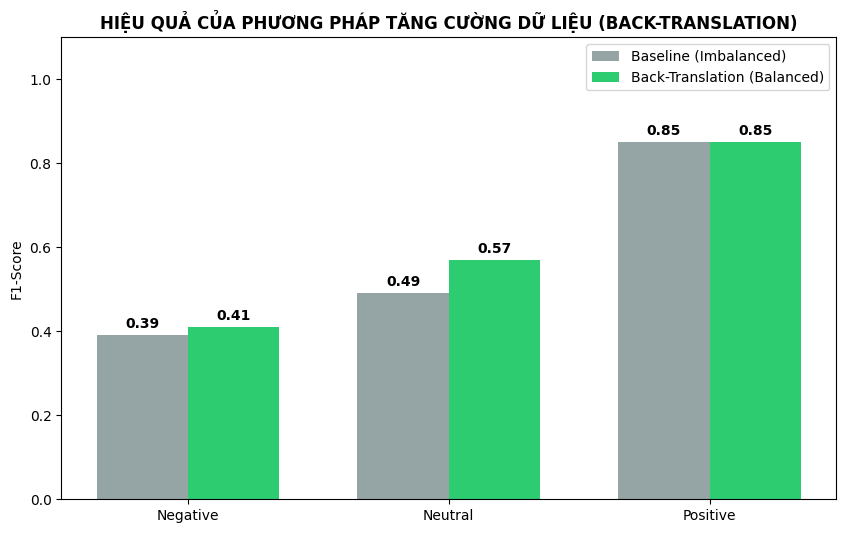

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Số liệu từ các lần chạy của bạn (Nhập tay từ các bảng classification_report)
labels = ['Negative', 'Neutral', 'Positive']

# F1-Score của Baseline (Dữ liệu gốc) - Lấy từ ảnh cũ của bạn
baseline_f1 = [0.39, 0.49, 0.85]

# F1-Score của Final Model (Back-Translation) - Lấy từ kết quả vừa chạy
final_f1 = [0.41, 0.57, 0.85]

x = np.arange(len(labels))  # Vị trí các nhãn
width = 0.35  # Độ rộng cột

fig, ax = plt.subplots(figsize=(10, 6))

# Vẽ 2 cột
rects1 = ax.bar(x - width/2, baseline_f1, width, label='Baseline (Imbalanced)', color='#95a5a6')
rects2 = ax.bar(x + width/2, final_f1, width, label='Back-Translation (Balanced)', color='#2ecc71')

# Trang trí
ax.set_ylabel('F1-Score')
ax.set_title('HIỆU QUẢ CỦA PHƯƠNG PHÁP TĂNG CƯỜNG DỮ LIỆU (BACK-TRANSLATION)', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0, 1.1) # Giới hạn trục y

# Hàm hiển thị số trên đầu cột
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.show()